In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving yelp.csv to yelp.csv


In [4]:
# load dataset
data = pd.read_csv('yelp.csv')

# show summary
data.describe(include='all')

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
count,10000,10000,10000,10000.000000,10000,10000,10000,10000.000000,10000.000000,10000.000000
unique,4174,1995,10000,NaN,9998,1,6403,NaN,NaN,NaN
top,JokKtdXU7zXHcr20Lrk29A,2011-03-28,fWKvX83p0-ka4JS3dc6E5A,NaN,Great service,review,fczQCSmaWF78toLEmb0Zsw,NaN,NaN,NaN
freq,37,21,1,NaN,2,10000,38,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.777500,NaN,NaN,NaN,0.876800,1.409300,0.701300
std,NaN,NaN,NaN,1.214636,NaN,NaN,NaN,2.067861,2.336647,1.907942
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,0.000000,1.000000,0.000000
75%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000


In [5]:
# create length column to hold length of word
data['length'] = data['text'].apply(len)
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469


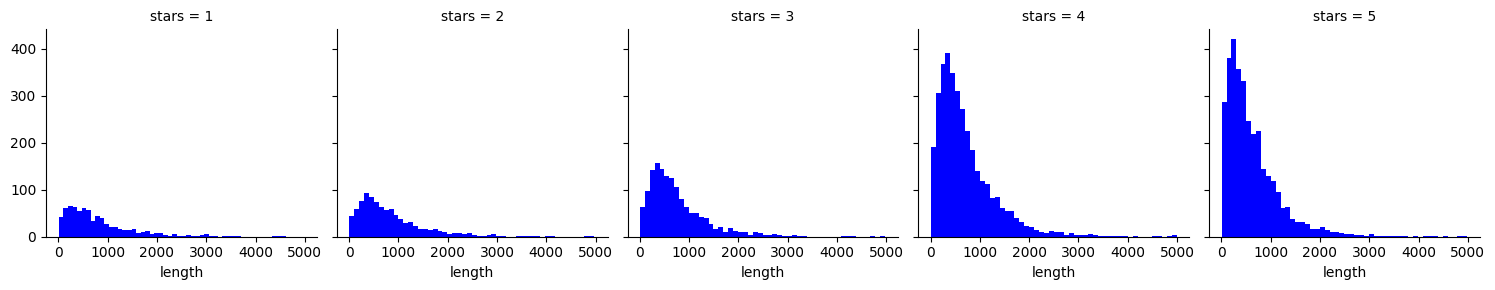

In [6]:
# compare stars to length
graph = sns.FacetGrid(data=data,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

In [7]:
# get mean value
stval = data.groupby('stars').mean()
stval

<ipython-input-7-9860ef109841>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stval = data.groupby('stars').mean()


,cool,useful,funny,length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [8]:
# calculate correlations
stval.corr()

,cool,useful,funny,length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
length,-0.857664,0.699881,0.843461,1.000000


In [11]:
# classification
data_classes = data[(data['stars']==1) | (data['stars']==3) | (data['stars']==5)]
data_classes.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565


In [12]:
data_classes.shape

(5547, 11)

In [14]:
# Seperate the dataset into X and Y for prediction
x = data_classes['text']
y = data_classes['stars']
x.head()

0    My wife took me here on my birthday for breakf...
1    I have no idea why some people give bad review...
3    Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4    General Manager Scott Petello is a good egg!!!...
6    Drop what you're doing and drive here. After I...
Name: text, dtype: object

In [15]:
y.head()

0    5
1    5
3    5
4    5
6    5
Name: stars, dtype: int64

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# generic function to preprocess text
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# convert to vectors
vocab = CountVectorizer(analyzer=text_process).fit(x)
r0 = x[0]
vocab0 = vocab.transform([r0])

len(vocab.vocabulary_)

In [19]:
x = vocab.transform(x)
# Shape of the matrix:
print("Shape of the sparse matrix: ", x.shape)

Shape of the sparse matrix:  (5547, 31336)


In [20]:
#Non-zero occurences:
print("Non-Zero occurences: ",x.nnz)


Non-Zero occurences:  312457


In [21]:
# matrix density
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

Density of the matrix =  0.17975812697942373


In [22]:
# split dataset into test and train
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=101)

In [23]:
# multilayer perceptron classifier
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 94  36  32]
 [ 24 188  80]
 [ 12  59 585]]
Score: 78.11
Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.58      0.64       162
           3       0.66      0.64      0.65       292
           5       0.84      0.89      0.86       656

    accuracy                           0.78      1110
   macro avg       0.74      0.71      0.72      1110
weighted avg       0.78      0.78      0.78      1110



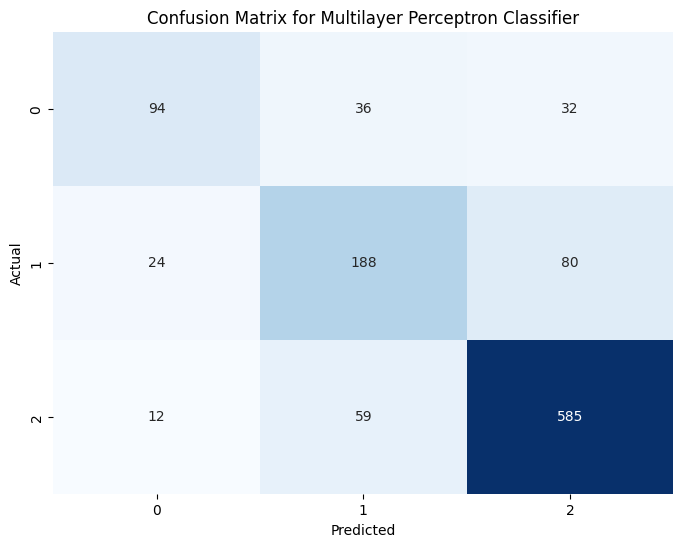

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, predmlp)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Multilayer Perceptron Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [27]:
# Print accuracy score and classification report
print("Score:", round(accuracy_score(y_test, predmlp) * 100, 2))
print("Classification Report:")
print(classification_report(y_test, predmlp))

Score: 78.11
Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.58      0.64       162
           3       0.66      0.64      0.65       292
           5       0.84      0.89      0.86       656

    accuracy                           0.78      1110
   macro avg       0.74      0.71      0.72      1110
weighted avg       0.78      0.78      0.78      1110



In [52]:
# Get random ratings predictions from the provided dataset
import random

for number in range(10):
    print(f"\nTest review {number+1}:")
    i = random.randint(0, len(data['text']))
    pr = data['text'][i]
    print(f"\t{pr[:150]}...")
    print("\tACTUAL RATING:   ",data['stars'][i])
    pr_t = vocab.transform([pr])
    print("\tPREDICTED RATING:", mlp.predict(pr_t)[0])



Test review 1:
	Seriously the most pathetic burger I've had.... ever? On the level of a Burger king or the like. With tip I paid $15 for the burger and fries. What a ...
	ACTUAL RATING:    2
	PREDICTED RATING: 1

Test review 2:
	Great location, great food, and nice ambiance.  The menu isn't huge, but this is a nice French cafe type setting if that's what you're into....
	ACTUAL RATING:    4
	PREDICTED RATING: 5

Test review 3:
	So sad closed. Oh well....
	ACTUAL RATING:    2
	PREDICTED RATING: 1

Test review 4:
	When I'm looking for the more mature, laid back version of Lux, I come to Copper Star. Coffee is not as good but service is great and place is invitin...
	ACTUAL RATING:    4
	PREDICTED RATING: 5

Test review 5:
	This place wasn't that great for the price.  I spent 15 on 2 mini grilled cheese sliders and a tea (basically bar food over priced) Not much to choose...
	ACTUAL RATING:    2
	PREDICTED RATING: 3

Test review 6:
	So this place was under another name from another fame,

In [56]:
# Sample negative custom review
sample_review = "This restaurant was a complete disaster. The food was tasteless, overpriced, and barely edible. The service was horrendous, with rude and inattentive staff. The ambiance was terrible, and the cleanliness of the place left much to be desired. I would not recommend this place to my worst enemy. It was a waste of time and money, and I left feeling thoroughly disappointed. Save yourself the trouble and avoid this establishment at all costs."

# Print the sample review
print("Sample Review:\n")
print(sample_review)

# Predict the rating using the fitted model and vocabulary
sample_review_transformed = vocab.transform([sample_review])
predicted_rating = mlp.predict(sample_review_transformed)[0]

# Print predicted rating
print("\nPREDICTED RATING:", predicted_rating)


Sample Review:

This restaurant was a complete disaster. The food was tasteless, overpriced, and barely edible. The service was horrendous, with rude and inattentive staff. The ambiance was terrible, and the cleanliness of the place left much to be desired. I would not recommend this place to my worst enemy. It was a waste of time and money, and I left feeling thoroughly disappointed. Save yourself the trouble and avoid this establishment at all costs.

PREDICTED RATING: 1


In [57]:
# Sample positive custom review
sample_review = "I had an amazing experience at this restaurant! The food was delicious, beautifully presented, and reasonably priced. The service was outstanding, with friendly and attentive staff who made sure we felt welcome. The ambiance was cozy and inviting, creating the perfect atmosphere for a delightful meal. I highly recommend this place to anyone looking for a fantastic dining experience. I'll definitely be coming back for more!"

# Print the sample review
print("Sample Review:\n")
print(sample_review)

# Predict the rating using the fitted model and vocabulary
sample_review_transformed = vocab.transform([sample_review])
predicted_rating = mlp.predict(sample_review_transformed)[0]

# Print predicted rating
print("\nPREDICTED RATING:", predicted_rating)


Sample Review:

I had an amazing experience at this restaurant! The food was delicious, beautifully presented, and reasonably priced. The service was outstanding, with friendly and attentive staff who made sure we felt welcome. The ambiance was cozy and inviting, creating the perfect atmosphere for a delightful meal. I highly recommend this place to anyone looking for a fantastic dining experience. I'll definitely be coming back for more!

PREDICTED RATING: 5


In [58]:
# Sample neutral custom review
sample_review = "My experience at this place was okay. The food was decent, but nothing extraordinary. The service was acceptable, though not particularly memorable. The prices were fair for what you get. The ambiance was standard, nothing special. Overall, it's an average spot to grab a quick bite, but I wouldn't go out of my way to visit again."

# Print the sample review
print("Sample Review:\n")
print(sample_review)

# Predict the rating using the fitted model and vocabulary
sample_review_transformed = vocab.transform([sample_review])
predicted_rating = mlp.predict(sample_review_transformed)[0]

# Print predicted rating
print("\nPREDICTED RATING:", predicted_rating)


Sample Review:

My experience at this place was okay. The food was decent, but nothing extraordinary. The service was acceptable, though not particularly memorable. The prices were fair for what you get. The ambiance was standard, nothing special. Overall, it's an average spot to grab a quick bite, but I wouldn't go out of my way to visit again.

PREDICTED RATING: 3


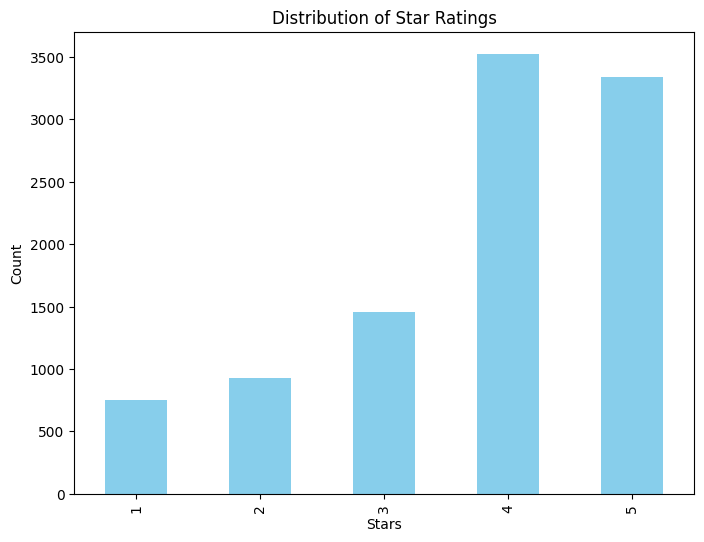

In [60]:
count = data['stars'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(8, 6))
count.plot(kind='bar', color='skyblue')
plt.title('Distribution of Star Ratings')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()
